In [2]:
save_dats_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/paper1/dats/'

In [3]:
from glob import glob
import pandas as pd
import fastwer
import numpy as np
import matplotlib.pyplot as plt
import re

import Levenshtein

from sys import path
path.append('../')

from utils import split_function_with_delimiters_with_checks as spc
from utils import get_fill_in_types, align_texts_fast

search_doc = r"\\(?:[^a-zA-Z]|[a-zA-Z]+[*=']?)" # search for commands in the document itself

# have some weird marks that don't show up in our text
marks = {'citations':'↫','refs':'↷','inlines':'↭'}

In [97]:
def fix_ocr(dfout_historical, marks=marks, predicted_text_col = 'predicted_text'):
    dfout_err_h = dfout_historical.copy()

    dfmask = []

    cer_orig = []; wer_orig = []
    cer_corr = []; wer_corr = []
    cer_corr_fix = []; wer_corr_fix = []
    cer_fix = []; wer_fix = []
    pdf_fix_out = []; ocr_fix_out = []
    for i in range(len(dfout_historical)):

        ocr = dfout_historical.iloc[i]['input_text']
        pdf = dfout_historical.iloc[i]['target_text']
        ocr_corr = dfout_historical.iloc[i][predicted_text_col]

 
        if pd.isnull(ocr) or pd.isnull(pdf) or pd.isnull(ocr_corr):
            pdf_fix_out.append(np.nan)
            ocr_fix_out.append(np.nan)
            cer_orig.append(np.nan)
            wer_orig.append(np.nan)
            cer_corr.append(np.nan)
            wer_corr.append(np.nan)
            cer_corr_fix.append(np.nan)
            wer_corr_fix.append(np.nan)
            cer_fix.append(np.nan)
            wer_fix.append(np.nan)
            dfmask.append(False)
            continue
            
        
       # orig
        ocr_orig = str(dfout_historical.iloc[i]['input_text'])
        pdf_orig = str(dfout_historical.iloc[i]['target_text'])
        ocr_corr_orig = str(dfout_historical.iloc[i]['predicted_text'])
        
        # count '$'
        #pdf_orig = str(pdf_orig)
        if list(pdf_orig).count('$')%2 != 0:
            pdf_fix_out.append(np.nan)
            ocr_fix_out.append(np.nan)
            cer_orig.append(np.nan)
            wer_orig.append(np.nan)
            cer_corr.append(np.nan)
            wer_corr.append(np.nan)
            cer_corr_fix.append(np.nan)
            wer_corr_fix.append(np.nan)
            cer_fix.append(np.nan)
            wer_fix.append(np.nan)
            dfmask.append(False)
            continue
            # print('uneven $!')
            # print(pdf_orig)
            # import sys; sys.exit()


            
        # if not, format
        ocr = str(ocr); pdf = str(pdf)
        ocr_corr = str(ocr_corr)

        # also, do with just taking out locations of citations, refs and inlines:
        # ------ 1. inline math --------
        ind = 0
        pdf_fix = ''
        while ind < len(pdf):
            if '$' in pdf[ind:]:
                i1 = pdf[ind:].index('$')
                try:
                    i2 = pdf[ind+i1+1:].index('$')+i1+1+1
                    # find match
                    pdf_fix += pdf[ind:ind+i1]
                    pdf_fix += marks['inlines']
                    #import sys; sys.exit()
                    ind += i2
                except:
                    print('matching $ not found, moving on...')
                    print('current:', pdf)
                    print('prior:', pdf_orig)
                    import sys; sys.exit()
                    ind += i1
            else:
                pdf_fix += pdf[ind:]
                ind += len(pdf[ind:])

        ind = 0
        ocr_corr_fix = ''
        while ind < len(ocr_corr):
            if '$' in ocr_corr[ind:]:
                i1 = ocr_corr[ind:].index('$')
                nope = False
                try:
                    i2 = ocr_corr[ind+i1+1:].index('$')+i1+1+1
                except:
                    print('no matching $ in OCR corrected fix!')
                    nope = True
                if not nope:
                    # find match
                    ocr_corr_fix += ocr_corr[ind:ind+i1]
                    ocr_corr_fix += marks['inlines']
                    #import sys; sys.exit()
                    ind += i2
                else:
                    ind += i1+1
            else:
                ocr_corr_fix += ocr_corr[ind:]
                ind += len(ocr_corr[ind:])

        # ------ 2. citations -----
        ind = 0
        pdf_fix2 = ''
        while ind < len(pdf_fix):
            if '\\cite' in pdf_fix[ind:]:
                ind1,ind2,err = spc(pdf_fix[ind:],function='\\cite',
                        dopen='{',dclose='}',
                       error_out=False)
                if ind1 != -1 and ind2 != -2:
                    pdf_fix2 += pdf_fix[ind:ind+ind1]
                    pdf_fix2 += marks['citations']
                    ind += ind2
                else:
                    ind += pdf_fix[ind:].index('\\cite')+len('\\cite')
            else:
                pdf_fix2 += pdf_fix[ind:]
                ind += len(pdf_fix[ind:])

        ind = 0
        ocr_corr_fix2 = ''
        while ind < len(ocr_corr_fix):
            if '\\cite' in ocr_corr_fix[ind:]:
                ind1,ind2,err = spc(ocr_corr_fix[ind:],function='\\cite',
                        dopen='{',dclose='}',
                       error_out=False)
                if not err:
                    ocr_corr_fix2 += ocr_corr_fix[ind:ind+ind1]
                    ocr_corr_fix2 += marks['citations']
                    ind += ind2
                else:
                    ind += ocr_corr_fix[ind:].index('\\cite')+len('\\cite')
            else:
                ocr_corr_fix2 += ocr_corr_fix[ind:]
                ind += len(ocr_corr_fix[ind:])

         # ------ 3. refs -----
        ind = 0
        pdf_fix3 = ''
        while ind < len(pdf_fix2):
            if '\\ref' in pdf_fix2[ind:]:
                ind1,ind2 = spc(pdf_fix2[ind:],function='\\ref',
                        dopen='{',dclose='}',
                       error_out=True)
                pdf_fix3 += pdf_fix2[ind:ind+ind1]
                pdf_fix3 += marks['refs']
                ind += ind2
            else:
                pdf_fix3 += pdf_fix2[ind:]
                ind += len(pdf_fix2[ind:])

        ind = 0
        ocr_corr_fix3 = ''
        while ind < len(ocr_corr_fix2):
            if '\\ref' in ocr_corr_fix2[ind:]:
                ind1,ind2 = spc(ocr_corr_fix2[ind:],function='\\ref',
                        dopen='{',dclose='}',
                       error_out=True)
                ocr_corr_fix3 += ocr_corr_fix2[ind:ind+ind1]
                ocr_corr_fix3 += marks['refs']
                ind += ind2
            else:
                ocr_corr_fix3 += ocr_corr_fix2[ind:]
                ind += len(ocr_corr_fix2[ind:])

        #if i == 5: import sys; sys.exit()

        # orig errors
        cer_orig_here = fastwer.score_sent(ocr_orig,pdf_orig, 
                                      char_level=True)
        wer_orig_here = fastwer.score_sent(ocr_orig,pdf_orig, 
                                      char_level=False)
        # after correction
        cer_corr_here = fastwer.score_sent(ocr_corr_orig,pdf_orig, 
                                      char_level=True)
        wer_corr_here = fastwer.score_sent(ocr_corr_orig,pdf_orig, 
                                      char_level=False)

        # after correction, with replacement
        cer_corr_fix_here = fastwer.score_sent(ocr_corr_fix3,pdf_fix3, 
                                      char_level=True)
        wer_corr_fix_here = fastwer.score_sent(ocr_corr_fix3,pdf_fix3, 
                                      char_level=False)

        # before correction, with replacement
        cer_fix_here = fastwer.score_sent(ocr,pdf_fix3, 
                                      char_level=True)
        wer_fix_here = fastwer.score_sent(ocr,pdf_fix3, 
                                      char_level=False)


        # ignore if we haven't checked for extra non-tracked things
        pdf_check = pdf_fix3.replace('*','').replace('`','').replace('$','')
        s = re.search(search_doc, pdf_check)
        if s: # skip
            pdf_fix_out.append(np.nan)
            ocr_fix_out.append(np.nan)
            cer_orig.append(np.nan)
            wer_orig.append(np.nan)
            cer_corr.append(np.nan)
            wer_corr.append(np.nan)
            cer_corr_fix.append(np.nan)
            wer_corr_fix.append(np.nan)
            cer_fix.append(np.nan)
            wer_fix.append(np.nan)
            dfmask.append(False)
            continue
        else:
            dfmask.append(True)


        pdf_fix_out.append(pdf_fix3)
        ocr_fix_out.append(ocr_corr_fix3)


        cer_orig.append(cer_orig_here)
        wer_orig.append(wer_orig_here)
        cer_corr.append(cer_corr_here)
        wer_corr.append(wer_corr_here)
        cer_corr_fix.append(cer_corr_fix_here)
        wer_corr_fix.append(wer_corr_fix_here)
        cer_fix.append(cer_fix_here)
        wer_fix.append(wer_fix_here)

    # recopy
    #dfout_err_h = dfout_historical.copy().loc[dfmask]

    dfout_err_h['CER Orig'] = cer_orig
    dfout_err_h['WER Orig'] = wer_orig
    dfout_err_h['CER Corrected'] = cer_corr
    dfout_err_h['WER Corrected'] = wer_corr
    dfout_err_h['CER Fix Corrected'] = cer_corr_fix
    dfout_err_h['WER Fix Corrected'] = wer_corr_fix
    dfout_err_h['CER Fix'] = cer_fix
    dfout_err_h['WER Fix'] = wer_fix
    dfout_err_h['target_text_fixed'] = pdf_fix_out
    dfout_err_h['predicted_text_fixed'] = ocr_fix_out
    dfout_err_h['masked entries'] = dfmask
    
    return dfout_err_h


In [5]:
#df_byt5_words_full_fix = fix_ocr(df_byt5_words_full.copy())

In [6]:
# make reverse marks
marks_rev = {}
for k,v in marks.items():
    marks_rev[v] = k
marks_rev

{'↫': 'citations', '↷': 'refs', '↭': 'inlines'}

## Batch inference byt5 -- only words, arXiv dataset

In [7]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex/'

ender = '_small_words' # 100k for training, 5k val

In [8]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words = d.copy()
    else: # others
        df_byt5_words = pd.concat([df_byt5_words,d],ignore_index=True)

In [9]:
df_byt5_words.head()

,aligned sentences source,aligned sentences target,sentences source,sentences target,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,words source aligned,words target aligned,input_text,target_text,predicted_text
0,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,They suggested that optical flux from the neu...
1,dust. temperatures of 35. 40. 45 and SOWKK are...,"dust@ temperatures of 35, 40, 45 and @@@K@ are...",dust. temperatures of 35. 40. 45 and SOWKK are...,"dust temperatures of 35, 40, 45 and K are abou...",WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW@ WWWWWWWWWWWW WW WWW WWW WW WWW @@@W@ WWW...,WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW WWWWWWWWWWWW WW WWW WWW WW WWW W WWW WWWW...,dust. temperatures of 35. 40. 45 and KK are ab...,"dust@ temperatures of 35, 40, 45 and K@ are ab...",dust. temperatures of 35. 40. 45 and KK are ab...,"dust temperatures of 35, 40, 45 and K are abou...","dust temperatures of 35, 40, 45 and K are abou..."
2,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,A comparison between the two panels demonstra...
3,Then. equation ^^^^^^^^^^^(7)^) aud equation ...,"Then, equation \ref{con_ang}) ) and equation ...",Then. equation (7)) aud equation (3)) can be ...,"Then, equation \ref{con_ang}) ) and equation ...",WWWWW WWWWWWWW ^^^^^^^^^^^WWW^W WWW WWWWWWWW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,WWWWW WWWWWWWW WWWW WWW WWWWWWWW WWWW WWW WW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,Then. equation )@) aud equation )@) can be so...,"Then, equation ) ) and equation ) ) can be so...",Then. equation )) aud equation )) can be solv...,"Then, equation ) ) and equation ) ) can be so...","Then, equation ) ) and equation ) ) can be so..."
4,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...


In [10]:
def calc_cer_wer(df_byt5_words, input_text_col = 'input_text', 
                target_text_col='target_text', predicted_text_col='predicted_text'):
    # input_text = OCR source in
    # target_text = ground truth 
    # predicted_text = predicted OCR text
    cer_before = []; cer_after = []
    wer_before = []; wer_after = []
    for i in range(len(df_byt5_words)):
        d = df_byt5_words.iloc[i]
        # before
        if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
            # also, for ints/floats that got read in
            input_text = str(d[input_text_col])
            target_text = str(d[target_text_col])
            predicted_text = str(d[predicted_text_col])
            cbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=True)
            wbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=False)
            # after
            cafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=True)
            wafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=False)
        else:
            cbefore = np.nan
            wbefore = np.nan
            cafter = np.nan
            wafter = np.nan

        cer_before.append(cbefore)
        wer_before.append(wbefore)
        cer_after.append(cafter)
        wer_after.append(wafter)

    df_byt5_words['CER Before'] = cer_before
    df_byt5_words['WER Before'] = wer_before
    df_byt5_words['CER After'] = cer_after
    df_byt5_words['WER After'] = wer_after
    return df_byt5_words

In [11]:
df_byt5_words = calc_cer_wer(df_byt5_words.copy())

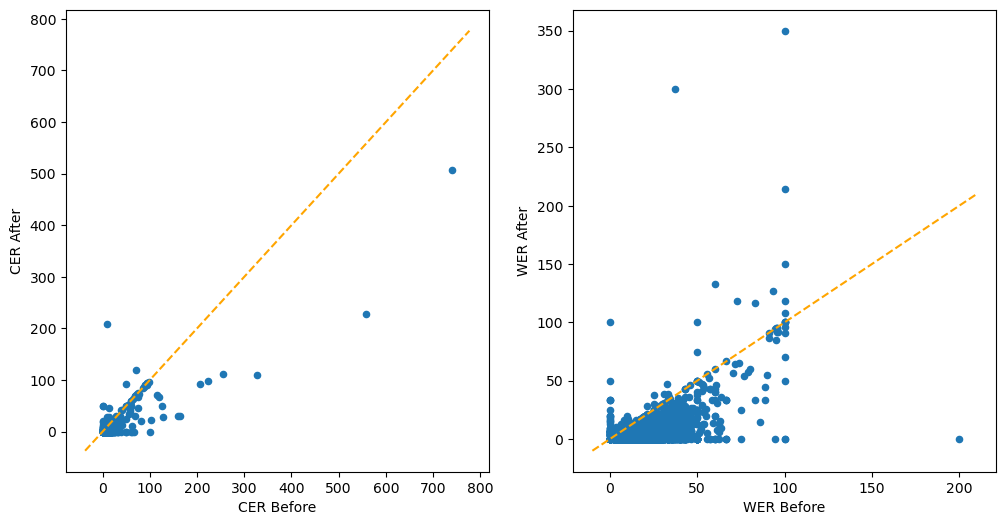

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [13]:
def get_iqr(df_byt5_words,col):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [14]:
def get_iqr_by_value(colvalue):
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [15]:
def get_stats(df_byt5_words,col, round_val = 2, print_nans=False):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    # how many nan's
    if print_nans: print('# NaNs =', len(df_byt5_words[col])-len(colvalue))
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)

In [16]:
def get_improvement_stats(df_byt5_words,col_before, col_after, round_val = 2):
    colvalueb = df_byt5_words[col_before]
    colvalueb = colvalueb[~np.isnan(colvalueb)]
    colvaluea = df_byt5_words[col_after]
    colvaluea = colvaluea[~np.isnan(colvaluea)]
    mask = colvalueb != 0
    colvalue = 100*(1-colvaluea[mask]/colvalueb[mask])
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)    

In [17]:
# x = 9.6
# format(x, '.2f')

In [18]:
def save_dat(fname,data,formatting = None, round_val = 2):
    if formatting == ',':
        all_arts = "{:,}".format(successful_align_pages)
    elif formatting == 'zfill':
        all_arts = data
        if 'NaN' not in str(all_arts):
            all_arts = format(all_arts,'.'+str(round_val)+'f')
    else:
        all_arts = data
    with open(fname, 'w') as f:
        print(all_arts, file=f,end='')

In [19]:
def get_print_stats(df_byt5_words, before='Before', after = 'After'):
    print('--------- Before -------------')
    mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words,'CER '+before, print_nans=True)
    print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
    mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words,'WER '+before)
    print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
    print('')
    print('--------- After -------------')
    mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words,'CER '+after)
    print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
    mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words,'WER '+after)
    print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
    print('')
    # improvement
    #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
    mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words,'CER '+before, 'CER '+after)
    print('------------ Improvement ----------------')
    print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
    mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words,'WER '+before, 'WER '+after)
    print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
    # numbers of better and worse
    # CER after should be < CER before if the model is corrected
    mask = df_byt5_words['CER '+before] < df_byt5_words['CER ' + after] # CER should go down after correction -- cer before correction < cer after is wrong -- how many wrong?
    print('CER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
          ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
    cerImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
    mask = df_byt5_words['WER '+before] < df_byt5_words['WER ' + after]
    print('WER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
         ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
    werImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
    
    return mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp

In [20]:
# print('')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
#      mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
#      mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full_fix, before=before, after = after)

In [21]:
# before = 'Before'; after = 'After'

# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
# # # numbers of better and worse
# # mask = test_data['CER '+before] < test_data['CER ' + after] # CER should go down after correction -- cer before correction < cer after is wrong -- how many wrong?
# # print('CER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
# #       ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
# # cerImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
# # mask = test_data['WER '+before] < test_data['WER ' + after]
# # print('WER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
# #      ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
# # werImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
# # # save all of these

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words, before='Before', after = 'After')

--------- Before -------------
# NaNs = 2
CER : mean = 5.5 , std = 17.46 , median = 3.01 , iqr = 5.22
WER : mean = 15.34 , std = 14.53 , median = 13.04 , iqr = 17.46

--------- After -------------
CER : mean = 2.08 , std = 11.16 , median = 0.0 , iqr = 1.31
WER : mean = 4.18 , std = 12.17 , median = 0.0 , iqr = 5.0

------------ Improvement ----------------
CER : mean =  75.6 , std = 54.01 , median = 100.0 , iqr = 36.44
WER : mean =  78.06 , std = 34.36 , median = 100.0 , iqr = 33.33
CER : How many better = 4843 , how many worse (or same) = 124 , % better = 97.5
WER : How many better = 4886 , how many worse (or same) = 81 , % better = 98.37


~~Also try with combining the full dataset:~~ this actually kills the kernel!

In [22]:
# before_all = ''; after_all = ''
# input_text_col = 'input_text'
# target_text_col='target_text'
# predicted_text_col='predicted_text'

# predicted_text_all = ''
# target_text_all = ''
# input_text_all = ''

# for i in range(len(df_byt5_words)):
#     d = df_byt5_words.iloc[i]
#     # before
#     if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
#         # also, for ints/floats that got read in
#         input_text = str(d[input_text_col])
#         target_text = str(d[target_text_col])
#         predicted_text = str(d[predicted_text_col])
        
#         predicted_text_all += predicted_text
#         target_text_all += target_text
#         input_text_all += input_text
        
# print('done')

# cbefore = fastwer.score_sent(input_text_all,
#                              target_text_all,
#                              char_level=True)
# wbefore = fastwer.score_sent(input_text_all,
#                              target_text_all,
#                              char_level=False)
# # after
# cafter = fastwer.score_sent(predicted_text_all,
#                              target_text_all,
#                              char_level=True)
# wafter = fastwer.score_sent(predicted_text_all,
#                              target_text_all,
#                              char_level=False)

# print(len(predicted_text_all), len(target_text_all), len(input_text_all))
# print(cbefore, wbefore)
# print(cafter,wafter)

In [23]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'byt5_onlyWords_small'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp','werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## Byt5, Historical, Only Words

In [24]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical/'

ender = '_small_words' # 100k for training, 5k val (in the arxiv data)

In [25]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h = d.copy()
    else: # others
        df_byt5_words_h = pd.concat([df_byt5_words_h,d],ignore_index=True)

In [26]:
df_byt5_words_h.head()

,input_text_unclean,target_text_unclean,filename,page,sent num,type,input_text,target_text,predicted_text
0,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he..."
1,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",1907ApJ____25__218B,9,0,plain,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",Both the nebula and the comet are seen on a n...
2,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...",1910ApJ____32___26R,6,11,plain,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d..."
3,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...",1913ApJ____38__407M,86,0,plain,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t..."
4,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...",1916ApJ____44___65W,4,3,plain,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...","An image of it was pro-jected upon the plate, ..."


In [27]:
df_byt5_words_h = calc_cer_wer(df_byt5_words_h.copy())

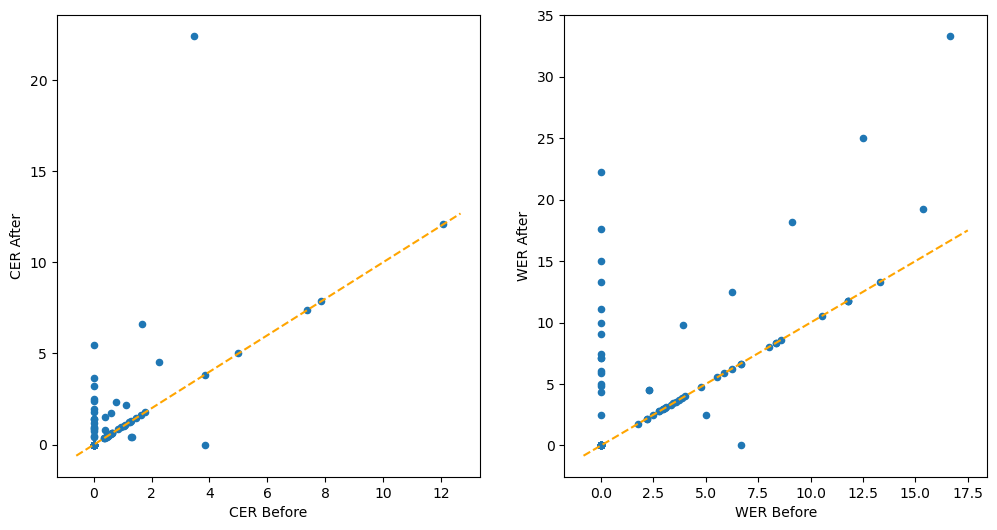

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_h.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_h.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [29]:
# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_h,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_h,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_h,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_h,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_h,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_h,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

# # save all of these
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h, before='Before', after = 'After')

--------- Before -------------
# NaNs = 0
CER : mean = 0.68 , std = 1.71 , median = 0.0 , iqr = 0.59
WER : mean = 2.37 , std = 3.9 , median = 0.0 , iqr = 3.48

--------- After -------------
CER : mean = 1.19 , std = 2.79 , median = 0.37 , iqr = 1.18
WER : mean = 4.21 , std = 6.1 , median = 2.17 , iqr = 6.35

------------ Improvement ----------------
CER : mean =  -39.43 , std = 117.01 , median = 0.0 , iqr = 0.0
WER : mean =  -15.24 , std = 46.39 , median = 0.0 , iqr = 0.0
CER : How many better = 84 , how many worse (or same) = 24 , % better = 77.78
WER : How many better = 84 , how many worse (or same) = 24 , % better = 77.78


So, just with words, doesn't really fix anything, which is interesting.

## byt5, full, arxiv

In [30]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex_full/'

ender = '_full_large' # 100k for training, 5k val

In [31]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_full = d.copy()
    else: # others
        df_byt5_words_full = pd.concat([df_byt5_words_full,d],ignore_index=True)

In [32]:
df_byt5_words_full.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m..."


In [33]:
df_byt5_words_full = calc_cer_wer(df_byt5_words_full.copy())

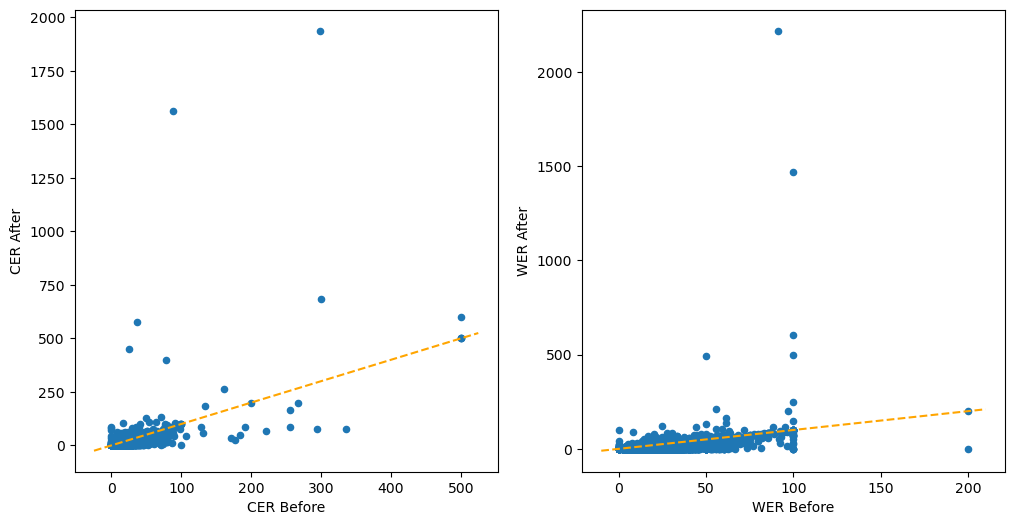

In [34]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_full.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_full.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [35]:
# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_full,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_full,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_full,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_full,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_full,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_full,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full, before='Before', after = 'After')

--------- Before -------------
# NaNs = 0
CER : mean = 12.52 , std = 18.57 , median = 8.11 , iqr = 14.79
WER : mean = 19.8 , std = 15.65 , median = 17.65 , iqr = 19.08

--------- After -------------
CER : mean = 7.08 , std = 31.36 , median = 1.49 , iqr = 8.59
WER : mean = 8.76 , std = 31.29 , median = 3.85 , iqr = 11.11

------------ Improvement ----------------
CER : mean =  58.67 , std = 80.35 , median = 72.73 , iqr = 60.0
WER : mean =  61.15 , std = 55.87 , median = 72.73 , iqr = 60.0
CER : How many better = 9318 , how many worse (or same) = 567 , % better = 94.26
WER : How many better = 9499 , how many worse (or same) = 386 , % better = 96.1


In [36]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w, cerImp, werImp]
names_start = 'byt5_full_large'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp', 'cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## byt5, full, with fixes

In [37]:
marks

{'citations': '↫', 'refs': '↷', 'inlines': '↭'}

In [38]:
# check that special marks aren't in the words just yet
for i in range(len(df_byt5_words_full)):
    d = df_byt5_words_full.iloc[i]
    for m in marks.values():
        #if m in d['input_text'] or m in d['target_text']:
        if m in str(d['target_text']):
            import sys; sys.exit()

In [39]:
df_byt5_words_full_fix = fix_ocr(df_byt5_words_full.copy(),marks=marks)

no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!


How many NaN's?

In [40]:
len(df_byt5_words_full_fix.loc[pd.isnull(df_byt5_words_full_fix['CER Fix'])])

84

In [41]:
df_byt5_words_full_fix.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text,CER Before,...,WER Orig,CER Corrected,WER Corrected,CER Fix Corrected,WER Fix Corrected,CER Fix,WER Fix,target_text_fixed,predicted_text_fixed,masked entries
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...,18.5393,...,25.0000,7.8652,9.3750,0.0000,0.0000,8.9172,22.5806,A histogram of the ↭ /slope for dwarf irregul...,A histogram of the ↭ /slope for dwarf irregul...,True
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...,4.5802,...,16.0000,0.0000,0.0000,0.0000,0.0000,4.5802,16.0000,We conclude that there does not appear to be ...,We conclude that there does not appear to be ...,True
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...,5.0000,...,7.6923,0.0000,0.0000,0.0000,0.0000,5.0000,7.6923,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,True
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...,4.3478,...,6.8966,0.0000,0.0000,0.0000,0.0000,4.3478,6.8966,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,True
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m...",4.8346,...,15.0000,0.7634,1.6667,0.7732,1.6949,3.6082,13.5593,"In general, it is well established that the m...","In general, it is well established that the m...",True


In [42]:
# df_byt5_words_full_fix = calc_cer_wer(df_byt5_words_full_fix.copy(), 
#                                       target_text_col='target_text_fixed', 
#                                      predicted_text_col = 'predicted_text_fixed')
# already calc'd in the fixing!

In [43]:
#df_byt5_words_full_fix.columns

In [44]:
#df_byt5_words_full_fix.plot(x='CER After', y = 'CER Fix Corrected') # why are these the same????

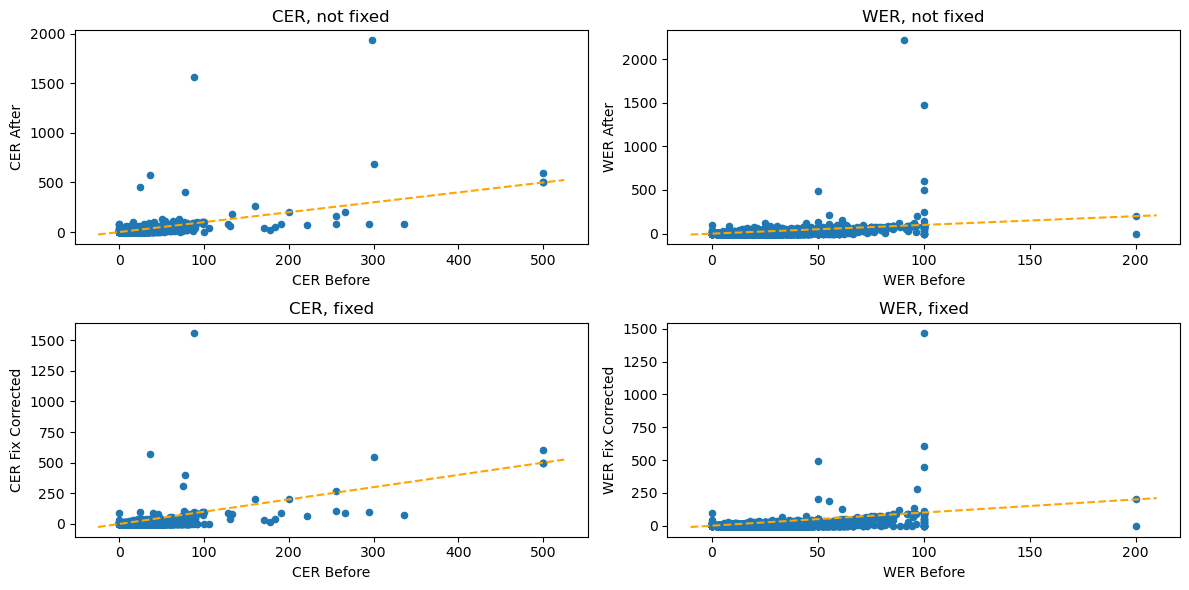

In [45]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.flatten()
df_byt5_words_full_fix.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[0].set_title('CER, not fixed')

df_byt5_words_full_fix.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[1].set_title('WER, not fixed')

# fixed
iplot = 2
df_byt5_words_full_fix.plot(x = 'CER Before', y = 'CER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('CER, fixed')

iplot = 3
df_byt5_words_full_fix.plot(x = 'WER Before', y = 'WER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('WER, fixed')

fig.tight_layout()

plt.show()

In [46]:
before = 'Before'
after = 'Fix Corrected'

# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_full_fix,'CER '+before, print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_full_fix,'WER '+before)
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_full_fix,'CER '+after)
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_full_fix,'WER '+after)
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_full_fix,'CER '+before, 'CER '+after)
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_full_fix,'WER '+before, 'WER '+after)
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
# print('')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full_fix, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 12.52 , std = 18.57 , median = 8.11 , iqr = 14.79
WER : mean = 19.8 , std = 15.65 , median = 17.65 , iqr = 19.08

--------- After -------------
CER : mean = 2.36 , std = 22.42 , median = 0.0 , iqr = 1.37
WER : mean = 3.59 , std = 19.57 , median = 0.0 , iqr = 4.17

------------ Improvement ----------------
CER : mean =  85.72 , std = 42.13 , median = 100.0 , iqr = nan
WER : mean =  85.19 , std = 32.85 , median = 100.0 , iqr = nan
CER : How many better = 9708 , how many worse (or same) = 177 , % better = 98.21
WER : How many better = 9812 , how many worse (or same) = 73 , % better = 99.26


In [47]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp, werImp]
names_start = 'byt5_full_large_fix'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp', 'cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## byt5, full, classification

In [48]:
def make_classification_metrics(dfout_err_h, target_text_col='target_text_fixed',
                               predicted_text_col='predicted_text_fixed',
                               marks = marks_rev):
    
    classification_metrics = {'citations':{'FP':0, 'FN':0, 'TP':0, 'total true':0}, 
                              'inlines':{'FP':0, 'FN':0, 'TP':0, 'total true':0},
                              'refs':{'FP':0, 'FN':0, 'TP':0, 'total true':0}}


    for i in range(len(dfout_err_h)):
        d = dfout_err_h.iloc[i]
        # align predicted and target
        page_text_gt = str(d[target_text_col])
        page_text_ocr = str(d[predicted_text_col])
        eops = Levenshtein.editops(page_text_ocr, page_text_gt)
        ocr_text_aligned, pdf_text_aligned = align_texts_fast(page_text_ocr, 
                                                              page_text_gt, 
                                                              eops)
        # loop
        for p,o in zip(pdf_text_aligned,ocr_text_aligned):
            if p in list(marks.keys()): # special mark
                if p == o: # got it!
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['TP'] += 1
                elif (p != o) and (o in list(marks.keys())): # not right mark, but in marks
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[o]]['FP'] += 1
                else: # p is a mark, but missed it in ocr
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['FN'] += 1
            elif o in list(marks.keys()): # have ocr instead!
                classification_metrics[marks[o]]['FP'] += 1
    return classification_metrics

def prec_rec_f1(classification_metrics):
    for t,v in classification_metrics.items():
        if v['total true'] > 0: # have it
            print(t)
            print(v)
            #Precision = TruePositives / (TruePositives + FalsePositives)
            if v['TP'] + v["FP"] > 0:
                prec = v['TP']/(v['TP'] + v["FP"])
            else:
                prec = 0
            #Recall = TruePositives / (TruePositives + FalseNegatives)
            if v['TP']+v['FN'] > 0:
                rec = v['TP']/(v['TP']+v['FN'])
            else:
                rec = 0

            # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
            if prec+rec > 0:
                f1 = (2*prec*rec)/(prec+rec)
            else:
                f1 = 0

            print('prec =', prec, ', rec =', rec, ', f1 = ', f1)
            print('')
            classification_metrics[t]['Prec'] = prec
            classification_metrics[t]['Rec'] = rec
            classification_metrics[t]['F1'] = f1
    return classification_metrics

In [49]:
#df_byt5_words_full_fix.head()

In [50]:
classification_metrics_latex = make_classification_metrics(df_byt5_words_full_fix)

In [51]:
print('-------- LaTeX ---------')
classification_metrics_latex = prec_rec_f1(classification_metrics_latex.copy())

-------- LaTeX ---------
citations
{'FP': 63, 'FN': 78, 'TP': 1503, 'total true': 1594}
prec = 0.9597701149425287 , rec = 0.9506641366223909 , f1 =  0.9551954242135368

inlines
{'FP': 537, 'FN': 767, 'TP': 6406, 'total true': 7181}
prec = 0.9226559124297854 , rec = 0.8930712393698592 , f1 =  0.9076225559648625

refs
{'FP': 102, 'FN': 82, 'TP': 968, 'total true': 1053}
prec = 0.9046728971962616 , rec = 0.9219047619047619 , f1 =  0.9132075471698115



In [52]:
classification_metrics_latex

{'citations': {'FP': 63,
  'FN': 78,
  'TP': 1503,
  'total true': 1594,
  'Prec': 0.9597701149425287,
  'Rec': 0.9506641366223909,
  'F1': 0.9551954242135368},
 'inlines': {'FP': 537,
  'FN': 767,
  'TP': 6406,
  'total true': 7181,
  'Prec': 0.9226559124297854,
  'Rec': 0.8930712393698592,
  'F1': 0.9076225559648625},
 'refs': {'FP': 102,
  'FN': 82,
  'TP': 968,
  'total true': 1053,
  'Prec': 0.9046728971962616,
  'Rec': 0.9219047619047619,
  'F1': 0.9132075471698115}}

In [53]:
for k,v in classification_metrics_latex.items():
    fdat = save_dats_dir + 'arxiv_' + k
    p = round(v['Prec']*100,2)
    r = round(v['Rec']*100,2)
    f1 = round(v['F1']*100,2)
    tot = int(v['total true'])
    for m,n in zip([p,r,f1],['prec','rec','f1']):
        save_dat(fdat + '_' + n + '.dat',m,formatting='zfill')
        
    save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
    
        # with open(fdat + '_' + n + '.dat','w') as f:
        #     print(m,file=f)

## byt5, NOT fixed historical

In [54]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [55]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full = d.copy()
    else: # others
        df_byt5_words_h_full = pd.concat([df_byt5_words_h_full,d],ignore_index=True)

In [56]:
df_byt5_words_h_full.head()

,input_text,target_text,filename,page,sent num,type,predicted_text,predicted_text_defaultModel
0,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...",NaN
1,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",1907ApJ____25__218B,9,0,plain,Both the nebula and the comet are seen on a n...,NaN
2,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...",1910ApJ____32___26R,6,11,plain,"A plate can be exposed night after night, if d...",NaN
3,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...",1913ApJ____38__407M,86,0,plain,"Fure only, we must assume that, as we ascend ...",a conclusion which seems to be a rather contr...
4,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...",1916ApJ____44___65W,4,3,plain,"An image of it was pro-jected upon the plate, ...",NaN


In [57]:
df_byt5_words_h_full = calc_cer_wer(df_byt5_words_h_full.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text')

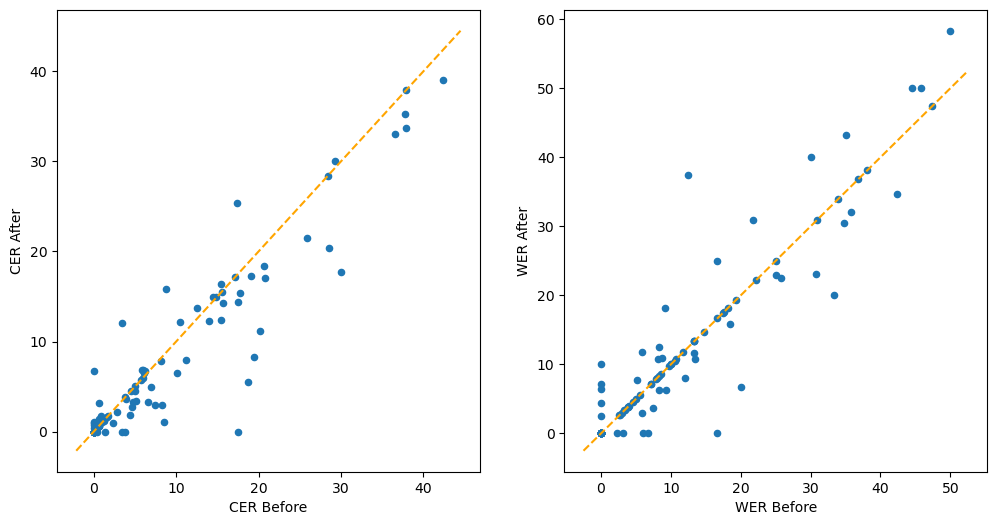

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_h_full.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_h_full.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [59]:
# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_h_full,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_h_full,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_h_full,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_h_full,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_h_full,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_h_full,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
before='Before'; after = 'After'
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 7.9 , std = 10.42 , median = 3.85 , iqr = 14.14
WER : mean = 11.17 , std = 12.91 , median = 7.28 , iqr = 16.67

--------- After -------------
CER : mean = 6.86 , std = 9.5 , median = 2.44 , iqr = 12.1
WER : mean = 11.38 , std = 13.56 , median = 7.14 , iqr = 16.85

------------ Improvement ----------------
CER : mean =  6.28 , std = 68.41 , median = 6.67 , iqr = 29.97
WER : mean =  2.49 , std = 43.3 , median = 0.0 , iqr = 11.25
CER : How many better = 88 , how many worse (or same) = 20 , % better = 81.48
WER : How many better = 89 , how many worse (or same) = 19 , % better = 82.41


## Byt5, *YES* fixed, historical

In [60]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [61]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full_fix = d.copy()
    else: # others
        df_byt5_words_h_full_fix = pd.concat([df_byt5_words_h_full_fix,d],ignore_index=True)

In [62]:
df_byt5_words_h_full_fix = calc_cer_wer(df_byt5_words_h_full_fix.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text')

In [63]:
# save number of instances
with open(save_dats_dir + 'n_historical.dat', 'w') as f:
    print(int(len(df_byt5_words_h_full_fix)),file=f)

In [64]:
df_byt5_words_h_full_fix = fix_ocr(df_byt5_words_h_full_fix.copy(), marks=marks)

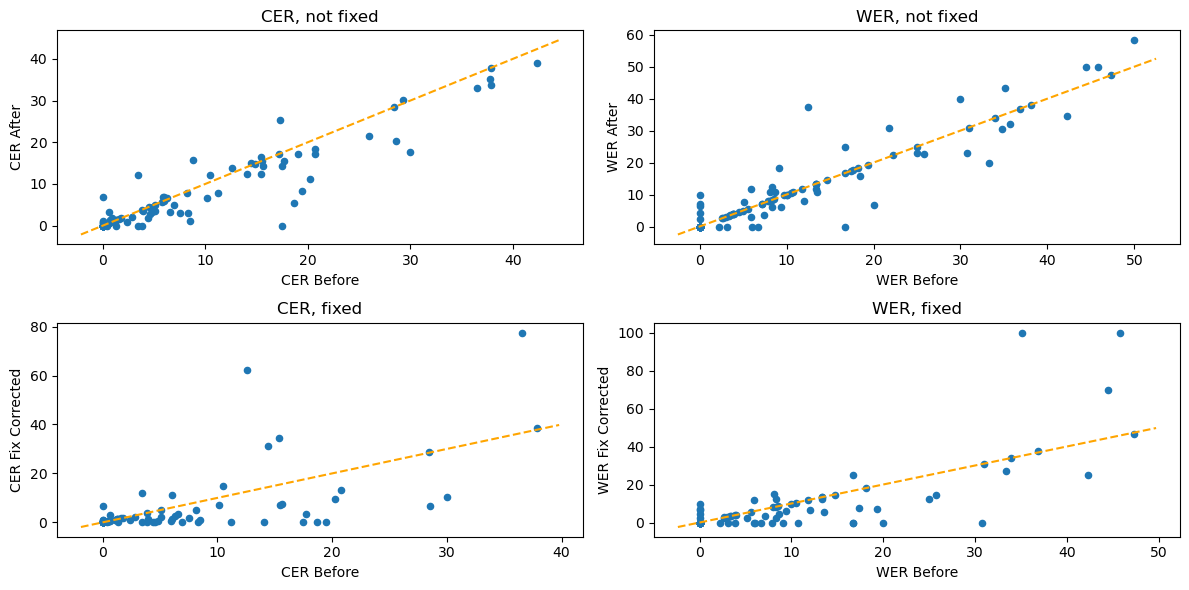

In [65]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.flatten()
df_byt5_words_h_full_fix.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[0].set_title('CER, not fixed')

df_byt5_words_h_full_fix.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[1].set_title('WER, not fixed')

# fixed
iplot = 2
df_byt5_words_h_full_fix.plot(x = 'CER Before', y = 'CER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('CER, fixed')

iplot = 3
df_byt5_words_h_full_fix.plot(x = 'WER Before', y = 'WER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('WER, fixed')

fig.tight_layout()

plt.show()

In [66]:
before = 'Before'
after = 'Fix Corrected'

# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_h_full_fix,'CER '+before, print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_h_full_fix,'WER '+before)
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_h_full_fix,'CER '+after)
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_h_full_fix,'WER '+after)
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_h_full_fix,'CER '+before, 'CER '+after)
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_h_full_fix,'WER '+before, 'WER '+after)
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full_fix, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 7.9 , std = 10.42 , median = 3.85 , iqr = 14.14
WER : mean = 11.17 , std = 12.91 , median = 7.28 , iqr = 16.67

--------- After -------------
CER : mean = 4.86 , std = 12.39 , median = 0.45 , iqr = 3.16
WER : mean = 8.95 , std = 18.01 , median = 2.63 , iqr = 10.0

------------ Improvement ----------------
CER : mean =  17.6 , std = 106.52 , median = 49.75 , iqr = nan
WER : mean =  23.05 , std = 61.38 , median = 0.74 , iqr = nan
CER : How many better = 93 , how many worse (or same) = 15 , % better = 86.11
WER : How many better = 95 , how many worse (or same) = 13 , % better = 87.96


In [67]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'byt5_full_large_fix_historical'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

In [68]:
classification_metrics_historical = make_classification_metrics(df_byt5_words_h_full_fix, marks=marks_rev)

In [69]:
print('-------- Historical ---------')
classification_metrics_historical = prec_rec_f1(classification_metrics_historical.copy())

-------- Historical ---------
citations
{'FP': 0, 'FN': 6, 'TP': 0, 'total true': 6}
prec = 0 , rec = 0.0 , f1 =  0

inlines
{'FP': 17, 'FN': 15, 'TP': 52, 'total true': 67}
prec = 0.7536231884057971 , rec = 0.7761194029850746 , f1 =  0.7647058823529411



In [70]:
classification_metrics_historical

{'citations': {'FP': 0,
  'FN': 6,
  'TP': 0,
  'total true': 6,
  'Prec': 0,
  'Rec': 0.0,
  'F1': 0},
 'inlines': {'FP': 17,
  'FN': 15,
  'TP': 52,
  'total true': 67,
  'Prec': 0.7536231884057971,
  'Rec': 0.7761194029850746,
  'F1': 0.7647058823529411},
 'refs': {'FP': 0, 'FN': 0, 'TP': 0, 'total true': 0}}

Print out befores/afters if the CER/WER is >0 and unchanged, or has gone down:

In [71]:
for k,v in classification_metrics_historical.items():
    fdat = save_dats_dir + 'historical_class_' + k
    if 'Prec' in v: # if not, then all zeros
        p = round(v['Prec']*100,2)
        r = round(v['Rec']*100,2)
        f1 = round(v['F1']*100,2)
        tot = int(v['total true'])
    else:
        p = 'NaN'; r = 'NaN'; f1 = 'NaN'
        tot = 0
        
    for m,n in zip([p,r,f1],['prec','rec','f1']):
        save_dat(fdat + '_' + n + '.dat',m,formatting='zfill')
        
    save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
        
    # save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
    # for m,n in zip([p,r,f1,tot],['prec','rec','f1','total']):
    #     with open(fdat + '_' + n + '.dat','w') as f:
    #         if m == 0 and 'tota' not in n:
    #             m = '0.0'
    #         print(m,file=f)

In [72]:
#df_byt5_words_h_full_fix.head()

In [73]:
istart = 0
iend = 3
for i in range(len(df_byt5_words_h_full_fix)):
    d = df_byt5_words_h_full_fix.iloc[i]
    if d['CER Fix Corrected'] >= d['CER Orig'] and d['CER Orig']>0:
        if i > istart and iend < iend:
            print('orig OCR :', d['input_text'])
            print('orig PDF :', d['target_text'])
            print('pred txt :', d['predicted_text'])
            print('')

In [74]:
for i in range(len(df_byt5_words_h_full_fix)):
    d = df_byt5_words_h_full_fix.iloc[i]
    if d['WER Fix Corrected'] >= d['WER Orig'] and d['WER Orig']>0:
        if i > istart and iend < iend:
            print('orig OCR :', d['input_text'])
            print('orig PDF :', d['target_text'])
            print('pred txt :', d['predicted_text'])
            print('')

## byt5, historical, not fixed, just plain byt5-small model (no transfer learning)

In [78]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [79]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full_orig = d.copy()
    else: # others
        df_byt5_words_h_full_orig = pd.concat([df_byt5_words_h_full_orig,d],ignore_index=True)

In [82]:
df_byt5_words_h_full_orig = calc_cer_wer(df_byt5_words_h_full_orig.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text_defaultModel')

In [84]:
before='Before'
after = 'After'
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full_orig, 
                                                                                        before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 7.9 , std = 10.42 , median = 3.85 , iqr = 14.14
WER : mean = 11.17 , std = 12.91 , median = 7.28 , iqr = 16.67

--------- After -------------
CER : mean = 101.49 , std = 52.47 , median = 79.01 , iqr = 63.05
WER : mean = 133.3 , std = 68.82 , median = 101.92 , iqr = 100.74

------------ Improvement ----------------
CER : mean =  -3079.72 , std = 4427.67 , median = -1081.82 , iqr = 2165.99
WER : mean =  -1186.19 , std = 1003.9 , median = -866.67 , iqr = 1352.23
CER : How many better = 0 , how many worse (or same) = 108 , % better = 0.0
WER : How many better = 0 , how many worse (or same) = 108 , % better = 0.0


### With fixing:

In [98]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full_orig_fix = d.copy()
    else: # others
        df_byt5_words_h_full_orig_fix = pd.concat([df_byt5_words_h_full_orig_fix,d],ignore_index=True)

In [99]:
df_byt5_words_h_full_orig_fix = calc_cer_wer(df_byt5_words_h_full_orig_fix.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text_defaultModel')

In [100]:
df_byt5_words_h_full_orig_fix = fix_ocr(df_byt5_words_h_full_orig_fix.copy(), 
                                        marks=marks, predicted_text_col='predicted_text_defaultModel')

no matching $ in OCR corrected fix!


In [102]:
before = 'Before'
after = 'Fix Corrected'

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp \
     = get_print_stats(df_byt5_words_h_full_orig_fix, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 7.9 , std = 10.42 , median = 3.85 , iqr = 14.14
WER : mean = 11.17 , std = 12.91 , median = 7.28 , iqr = 16.67

--------- After -------------
CER : mean = 110.08 , std = 63.79 , median = 80.77 , iqr = 73.95
WER : mean = 141.73 , std = 80.64 , median = 106.25 , iqr = 108.86

------------ Improvement ----------------
CER : mean =  -3577.03 , std = 4642.53 , median = -1303.48 , iqr = nan
WER : mean =  -1307.62 , std = 1027.93 , median = -933.7 , iqr = nan
CER : How many better = 19 , how many worse (or same) = 89 , % better = 17.59
WER : How many better = 19 , how many worse (or same) = 89 , % better = 17.59


In [105]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'historical_untrained_'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill',round_val=0)

## byt5, historical data, trained on historical data

In [106]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_p = d.copy()
    else: # others
        df_byt5_words_h_p = pd.concat([df_byt5_words_h_p,d],ignore_index=True)

In [107]:
df_byt5_words_h_p.head(n=1)

,input_text,target_text,filename,page,sent num,type,predicted_text,predicted_text_defaultModel,predicted_text_histOnlyModel
0,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...","one year of age, he was appointed tem-porary ...","In 1859, when only twenty-one years of age, he..."


In [108]:
df_byt5_words_h_p = calc_cer_wer(df_byt5_words_h_p.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text_histOnlyModel')

In [110]:
df_byt5_words_h_p = fix_ocr(df_byt5_words_h_p.copy(), 
                            marks=marks, predicted_text_col='predicted_text_histOnlyModel')

no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!


In [111]:
before='Before'
after = 'After'

print(' *************** Not Fixed ******************** ')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_p, 
                                                                                        before=before, after = after)

 *************** Not Fixed ******************** 
--------- Before -------------
# NaNs = 6
CER : mean = 6.86 , std = 9.13 , median = 3.12 , iqr = 10.41
WER : mean = 9.98 , std = 12.05 , median = 6.36 , iqr = 13.33

--------- After -------------
CER : mean = 29.37 , std = 161.59 , median = 4.62 , iqr = 21.62
WER : mean = 30.72 , std = 141.21 , median = 7.52 , iqr = 25.0

------------ Improvement ----------------
CER : mean =  -340.88 , std = 1292.84 , median = 0.0 , iqr = 51.93
WER : mean =  -204.26 , std = 896.16 , median = 0.0 , iqr = 48.72
CER : How many better = 67 , how many worse (or same) = 41 , % better = 62.04
WER : How many better = 75 , how many worse (or same) = 33 , % better = 69.44


In [116]:
#df_byt5_words_h_p.columns

In [117]:
before = 'Before'
after = 'Fix Corrected'

print(' *************** Fixed ******************** ')

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp \
     = get_print_stats(df_byt5_words_h_p, before=before, after = after)

 *************** Fixed ******************** 
--------- Before -------------
# NaNs = 6
CER : mean = 6.86 , std = 9.13 , median = 3.12 , iqr = 10.41
WER : mean = 9.98 , std = 12.05 , median = 6.36 , iqr = 13.33

--------- After -------------
CER : mean = 29.67 , std = 148.54 , median = 1.63 , iqr = 16.85
WER : mean = 33.03 , std = 152.56 , median = 5.72 , iqr = 22.86

------------ Improvement ----------------
CER : mean =  -417.69 , std = 1318.62 , median = 0.0 , iqr = nan
WER : mean =  -255.32 , std = 1008.05 , median = 0.0 , iqr = nan
CER : How many better = 74 , how many worse (or same) = 34 , % better = 68.52
WER : How many better = 75 , how many worse (or same) = 33 , % better = 69.44


In [118]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'historical_onlyHist_'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill',round_val=2)